In [1]:
import allel
from allel.stats.diversity import mean_pairwise_difference, \
    mean_pairwise_difference_between
from allel.util import asarray_ndim, check_dim0_aligned, ensure_dim1_aligned
from allel.model.ndarray import GenotypeArray
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from glob import glob 
import colormap
import matplotlib.font_manager as font_manager


pd.options.mode.chained_assignment = None  # default='warn'
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

In [2]:
c = colormap.Colormap()
mycmap = c.cmap_linear("#696172", "#cfcfe3", "#f5f6fa")

In [3]:
font_dir = ["azure/font"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# functions

In [12]:
def calculate_fst(p1, p2, n1, n2): 
    
    e1 = (p1-p2)**2 
    e2 = (p1*(1-p1))/(n1-1)
    e3 = (p2*(1-p2))/(n2-1)
    
    n = e1-e2-e3
    d = (p1*(1-p2)) + (p2*(1-p1))
    
    return n, d
    

In [13]:
def get_fst(pop1, pop2): 
    
    p1, n1 = pop1[:, 0], pop1[:, 1]
    p2, n2 = pop2[:, 0], pop2[:, 1]
    n, d = calculate_fst(p1, p2, n1, n2)
    
    return n, d
    

# atlas fam 

In [4]:
df = pd.read_csv("azure/previous_reference/ilash/louvain_subclusters_redone/louvain_subclusters2_8.csv", header=None)

In [5]:
df["fam"] = 0 

In [5]:
for i in [0, 1, 2, 3]:
    cluster1 = df[df[1] == i]
    cluster1[["fam", 0]].to_csv(f"azure/fst/mex2/mex2_8_{i}.fam", index=False, sep="\t", header=None)
    

In [6]:
# for i, name in enumerate(df[1].unique()):
#     df1 = df[df[1] == name]
#     df1[["fam", 0]].to_csv(f"azure/gillian_maf/atlas_samples/community{i}.txt", sep="\t", header=None, index=False)
    

In [8]:
# df1 = df[df[1] == "muslim arab"]

In [9]:
# df1[["fam", 0]].to_csv("fst/am.fam", index=False, sep="\t", header=None)

In [10]:
# cluster = pd.read_csv("azure/previous_reference/ilash/louvain_subclusters_redone/louvain_subclusters3_7.csv", header=None)
# # cluster1["split_id"] = cluster1[0].str.split("_").str[1]
# cluster["fam"] = 0     
# cluster["group"] = "group" + cluster[1].astype(str)
# cluster[["fam", 0, "group"]].to_csv(f"fst/cluster3_7.fam", index=False, sep="\t", header=None)


In [12]:
df = pd.read_csv("top_community_ids.csv", header=None)
df["fam"] = 0 

In [13]:
df[1].unique()

array(['European', 'mexican and other hispanic/latino',
       'ashkenazi jewish', 'african american and afro-caribbean I',
       'chinese', 'filipino', 'japanese', 'korean', 'armenian',
       'persian muslim', 'punjabi + bengali', 'puerto rican', 'nigerian',
       'telugu', 'vietnamese', 'persian jewish', 'christian arab I',
       'pakistani', 'gujrati I', 'gujrati II', 'sindhi muslim',
       'christian arab II', 'colombian', 'pacific islander',
       'african american and afro-caribbean II', 'muslim arab',
       'Other Black?'], dtype=object)

In [16]:
df1 = df[df[1] == "nigerian"]
df1[["fam", 0]].to_csv(f"fst/aa3.fam", index=False, sep="\t", header=None)


# hudson fst calculations

In [10]:
def hudson_fst(ac1, ac2, fill=np.nan):

    # calculate these once only
    an1 = np.sum(ac1, axis=1)
    an2 = np.sum(ac2, axis=1)

    # calculate average diversity (a.k.a. heterozygosity) within each
    # population
    within = (mean_pairwise_difference(ac1, an1, fill=fill) +
              mean_pairwise_difference(ac2, an2, fill=fill)) / 2

    # calculate divergence (a.k.a. heterozygosity) between each population
    between = mean_pairwise_difference_between(ac1, ac2, an1, an2, fill=fill)

    # define numerator and denominator for Fst calculations
    num = between - within
    den = between

    return num, den

In [11]:
def get_allele_counts(df, sample):

    ac = np.empty(shape=(len(df), 3))
    counts = df[sample].str.split(":")
    
    for i, count in enumerate(counts): 
        if len(count) == 3: 
            ac[i, :] = count[0], count[1], count[2]
            
    return ac.astype(int) 

In [12]:
def get_common_sites(df1, df2):
    
    df1["site"] = df1["CHR"].astype(str) + ":" + df1["START"].astype(str)
    df2["site"] = df2["#CHROM"].astype(str) + ":" + df2["POS"].astype(str)
    
    common_sites = set(df1["site"]).intersection(df2["site"])
    
    return df1[df1["site"].isin(common_sites)].drop_duplicates(subset=["site"]), df2[df2["site"].isin(common_sites)]


# GME

### clean data 

In [25]:
gme = pd.read_csv("azure/near_east/gme_hg38.txt", delimiter="\t", low_memory=False)

In [26]:
gme = gme[gme.NWA.astype(str).str.contains(":")]
gme = gme[gme.NEA.astype(str).str.contains(":")]
gme = gme[gme.AP.astype(str).str.contains(":")]
gme = gme[gme.Israel.astype(str).str.contains(":")]
gme = gme[gme.SD.astype(str).str.contains(":")]
gme = gme[gme.TP.astype(str).str.contains(":")]
gme = gme[gme.CA.astype(str).str.contains(":")]

### fst for one population 

In [28]:
fst_mat = np.empty(shape=(6, 7))

for j, me_pop in enumerate(["NWA", "NEA", "AP", "Israel", "SD", "TP", "CA"]):
    
    for i, louvain_pop in enumerate(["pj", "pm", "arm", "ca1", "ca2", "am"]): 
        
        louvain_pop_df = pd.read_csv(f"fst/{louvain_pop}.gcount", delimiter="\t")
        g, l = get_common_sites(gme, louvain_pop_df)
        
        me = get_allele_counts(g, me_pop)
        print(me)

        lp = l.iloc[:, 5:8].values
        
        num, den  = allel.hudson_fst(lp, me)
        fst = np.sum(num) / np.sum(den)
        
        fst_mat[i, j] = fst  
  

[[91  2  1]
 [90  9  0]
 [94  1  1]
 ...
 [91  8  0]
 [99  0  0]
 [94  5  0]]


In [16]:
gme_pop_labels = ["northwest africa", "northeast africa", "arabian pennisula", "israel", "syrian desert", "turkish pennisula", "central asia"]
louvain_pop_labels = [ "persian jewish", "persian muslim", "armenian", "arab christian I", "arab christian II", "arab muslim"]

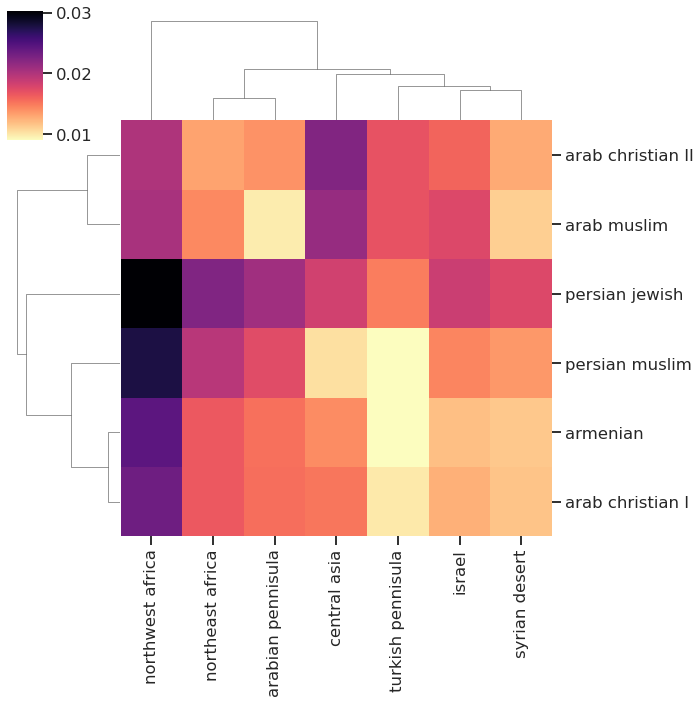

In [20]:
sns.clustermap(fst_mat, xticklabels=gme_pop_labels, 
            yticklabels=louvain_pop_labels, cmap="magma_r")
plt.show()

# Non-UK UKBB

In [7]:
def read_geno_file(fname): 
    
    df = pd.read_csv(fname, delimiter="\t")
    df["sum"] = df["HOM_REF_CT"].astype(int) + df["HET_REF_ALT1_CT"].astype(int) + df["HOM_ALT1_CT"].astype(int)
    df = df[df["sum"]>=5].dropna()
    
    return df

In [8]:
def get_minor_allele(a1, a2, a3): 
    AA = a1/(a1+a2+a3)
    Aa = a2/(a1+a2+a3)
    return 1 - ((Aa*0.5)+(AA))

In [9]:
def get_size(a1, a2, a3): 
    return 2*(a1+a2+a3)

In [10]:
def calculate_fst(p1, p2, n1, n2): 
    
    e1 = (p1-p2)**2 
    e2 = (p1*(1-p1))/(n1-1)
    e3 = (p2*(1-p2))/(n2-1)
    n = e1-e2-e3
    d = (p1*(1-p2)) + (p2*(1-p1))
    
    return n, d
    

In [11]:
def calculate_af(pop, i): 
    p = 1-get_minor_allele(pop[i][0], pop[i][1], pop[i][2])
    n = get_size(pop[i][0], pop[i][1], pop[i][2])
    
    return p, n

In [12]:
def get_fst(pop1, pop2): 
    numerators = []
    denominators = []
    for i in range(len(pop1)): 
        p1, n1 = calculate_af(pop1, i)
        p2, n2 = calculate_af(pop2, i)
        
        n, d = calculate_fst(p1, p2, n1, n2)
    
        numerators.append(n)
        denominators.append(d)
        
    return numerators, denominators
    

In [13]:
european_uk = glob("azure/non_uk/*.gcount")

In [14]:
atlas_eur = glob("azure/fst/eur_7/*.gcount")

In [15]:
files = atlas_eur + european_uk

In [302]:
fst_mat = np.zeros(shape=(len(european_uk), len(atlas_eur)))

for i in range(len(european_uk)):
    
    for j in range(len(atlas_eur)):
        
#         print(european_uk[i], atlas_eur[j])
        df1 = read_geno_file(european_uk[i])
        df2 = read_geno_file(atlas_eur[j])
        
        intersect = set(df1["ID"]).intersection(set(df2["ID"]))
        
        pop1 = df1[df1["ID"].isin(intersect)].iloc[:, 5:8].values.astype(int)
        pop2 = df2[df2["ID"].isin(intersect)].iloc[:, 5:8].values.astype(int)
#         print(pop1[0], pop2[0])

                
        num, den  = get_fst(pop1, pop2)
        fst = np.mean(num)/np.mean(den)
#         print(fst)
        fst_mat[i, j] = fst
        
        num, den  = allel.hudson_fst(pop1, pop2)
        fst = np.sum(num) / np.sum(den)
#         print(fst)


In [266]:
print(atlas_eur[0], atlas_eur[1])
df1 = read_geno_file(atlas_eur[0])
df2 = read_geno_file(atlas_eur[1])

intersect = set(df1["ID"]).intersection(set(df2["ID"]))

pop1 = df1[df1["ID"].isin(intersect)].iloc[:, 5:8].values.astype(int)
pop2 = df2[df2["ID"].isin(intersect)].iloc[:, 5:8].values.astype(int)
#         print(pop1[0], pop2[0])


num, den  = get_fst(pop1, pop2)
fst = np.mean(num)/np.mean(den)
print(fst)



azure/fst/eur_7/3_7_0.gcount azure/fst/eur_7/3_7_1.gcount
0.002899353422200019
0.0034847042961965394


In [242]:
xlabels = [0, 1, 2, 3] 
ylabels = [i.split("/")[-1].split(".")[0]for i in european_uk]

In [243]:
xlabels

[0, 1, 2, 3]

In [244]:
df = pd.DataFrame(fst_mat)
df.columns = xlabels
df["country"] = ylabels
df = df[df["country"] != "Serbia"]

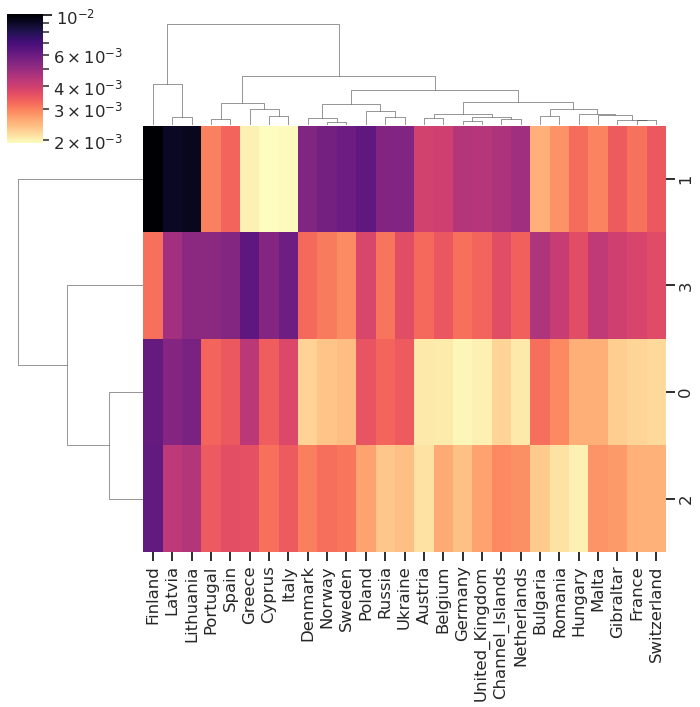

In [245]:
sns.clustermap(df[xlabels].T, yticklabels=xlabels, xticklabels=df["country"].values, 
            norm=LogNorm(),cmap="magma_r")
plt.show()

# gillian data 

In [4]:
def calculate_fst(p1, p2, n1, n2): 
    
    e1 = (p1-p2)**2 
    e2 = (p1*(1-p1))/(n1-1)
    e3 = (p2*(1-p2))/(n2-1)
    
    n = e1-e2-e3
    d = (p1*(1-p2)) + (p2*(1-p1))
    
    return n, d
    

In [5]:
def get_fst(pop1, pop2): 
    
    p1, n1 = pop1[:, 0], pop1[:, 1]
    p2, n2 = pop2[:, 0], pop2[:, 1]
    n, d = calculate_fst(p1, p2, n1, n2)
    
    return n, d
    

In [6]:
fst_mat = np.zeros(shape=(19, 27))

for i in range(1, 20):
    
    for j in range(0, 27):
        print(i, j)
        
        df1 = pd.read_csv(f"azure/gillian_maf/community{i}.txt", delimiter="\t", header=None)
        df1.columns = ["#CHROM", "ID", "REF", "ALT", "ALT_FREQS", "OBS_CT"]
        
        df2 = pd.read_csv(f"azure/gillian_maf/atlas_samples/community{j}.afreq", delimiter="\t")
            
        merge = df1.merge(df2, on=["ID"])
        merge["flip"] = np.where(merge["REF_x"]!=merge["REF_y"], 1-merge["ALT_FREQS_y"], merge["ALT_FREQS_y"])
            
        pop1 = merge[["ALT_FREQS_x", "OBS_CT_x"]].values
        pop2 = merge[["flip", "OBS_CT_y"]].values
        
        num, den = get_fst(pop1, pop2)

        fst = np.mean(num)/np.mean(den)
        fst_mat[i-1, j] = fst

        print(fst)

            
    

1 0
0.015315882729234755
1 1
0.013728582570381256
1 2
0.015714108995792255
1 3
0.035276503731831374
1 4
0.0703413219068267
1 5
0.06522316383948953
1 6
0.07199215564305608
1 7
0.07308136655516624
1 8
0.01709482036382502
1 9
0.015656366372744795
1 10
0.02161497315909645
1 11
0.0022148098163614774
1 12
0.06959281581492194
1 13
0.027990967701457408
1 14
0.0729492168001566
1 15
0.02057344311029241
1 16
0.014662484057211711
1 17
0.015865145194904822
1 18
0.01247139905498728
1 19
0.03161649161453924
1 20
0.020498662505829098
1 21
0.014125853091112412
1 22
0.009007891337198226
1 23
0.02247545951672712
1 24
0.01163082837224136
1 25
0.015350070884544155
1 26
0.048058846512372265
2 0
0.005960715453731174
2 1
0.022085382175548746
2 2
0.00011922800123562563
2 3
0.07672488565759808
2 4
0.08608470321601061
2 5
0.07972199692538369
2 6
0.08812696510183861
2 7
0.08936062785750606
2 8
0.00521311711208574
2 9
0.00666940641545651
2 10
0.022212418657867865
2 11
0.009414573900801096
2 12
0.12130832001886101


0.029054422287737285
13 2
0.02883287633451187
13 3
0.07726427737159644
13 4
0.06348056629516835
13 5
0.05852773173448308
13 6
0.06588503327820878
13 7
0.06724739610259044
13 8
0.024540513531807383
13 9
0.018140543511712143
13 10
0.0024698871851310065
13 11
0.024009198792525346
13 12
0.11832744155924692
13 13
0.0026094474006917345
13 14
0.06546960065286139
13 15
0.027913199538336236
13 16
0.026534392534575343
13 17
0.010110139888956085
13 18
0.007014828357100843
13 19
0.00022758368447969068
13 20
0.006947021471527677
13 21
0.03165934692320864
13 22
0.026455282411936416
13 23
0.026209310362024455
13 24
0.045533587242302054
13 25
0.030324341832564678
13 26
0.09236728975803768
14 0
0.024175321620183148
14 1
0.023389847725777544
14 2
0.024642277493175286
14 3
0.07249785654313363
14 4
0.05625300801661367
14 5
0.05165161292733701
14 6
0.05885171725551061
14 7
0.06010727537349045
14 8
0.021352762276027733
14 9
0.015488468201463223
14 10
0.0001509197509547503
14 11
0.018823353823838995
14 12
0.

In [7]:
fst_df = pd.DataFrame(abs(fst_mat))

In [8]:
xlabels = pd.read_csv("my_ids.txt", header=None)[0].values
ylabels = pd.read_csv("gillian_communities", header=None, delimiter="\t")

In [9]:
fst_df.columns = xlabels
fst_df["gillian number"] = list(range(1, 20)) 

In [10]:
fst_df = fst_df.merge(ylabels, left_on="gillian number", right_on=1)

In [11]:
fst_df = fst_df.set_index(0)

In [12]:
fst_df = fst_df.drop(["gillian number", 1], axis=1)

In [13]:
fst_df = fst_df.drop(["Black IV", "Gujarati I"], axis=1)

In [14]:
font_dir = ["azure/font"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

In [15]:
c = colormap.Colormap()
mycmap = c.cmap_linear("#696172", "#cfcfe3", "#f5f6fa")

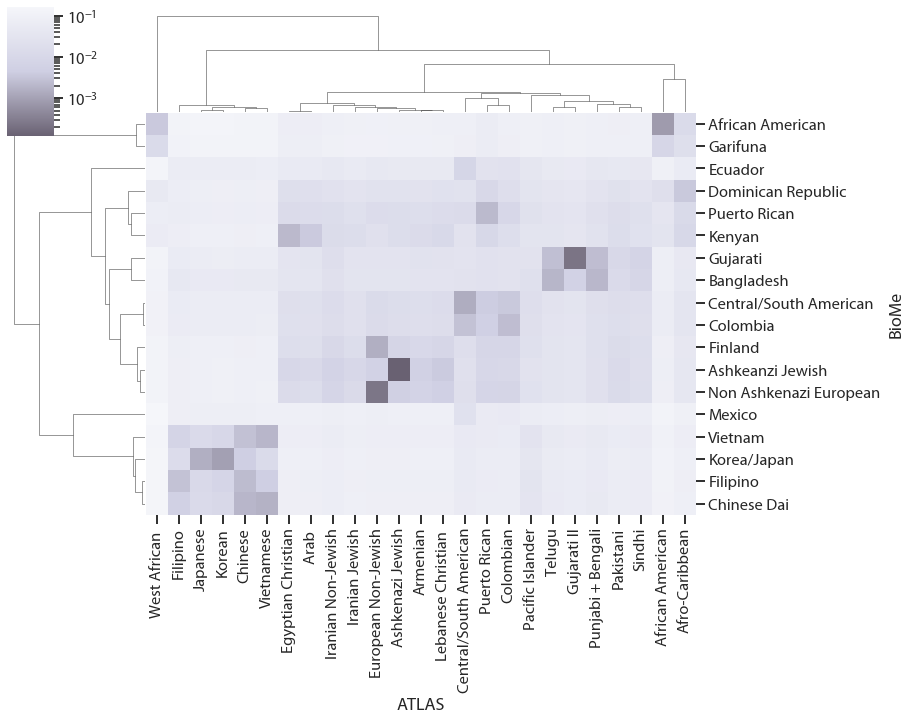

In [16]:
plt.rcParams['font.family'] = 'Myriad Pro'

g = sns.clustermap(fst_df, cmap=mycmap, figsize=(13, 10), yticklabels=1, norm=LogNorm())
ax = g.ax_heatmap

ax.set_ylabel("BioMe")
ax.set_xlabel("ATLAS")
# plt.show()
plt.savefig("fst_gillian.eps", format='eps')


In [18]:
fst_df["Vietnamese"].sort_values()

0
Chinese Dai                0.001722
Vietnam                    0.001994
Filipino                   0.004542
Korea/Japan                0.013187
Bangladesh                 0.049888
Gujarati                   0.065470
Central/South American     0.065528
Colombia                   0.067279
Ecuador                    0.069733
Puerto Rican               0.072949
Dominican Republic         0.079539
Kenyan                     0.081857
Finland                    0.084066
Mexico                     0.084470
Ashkeanzi Jewish           0.088579
Non Ashkenazi European     0.089057
Garifuna                   0.121785
African American           0.128134
Name: Vietnamese, dtype: float64

# mexico subclusters 

In [20]:
len([0, 2, 4, 5, 6, 7, 8])

7

In [26]:
fst_mat = np.zeros(shape=(19, 7))

for i in range(1, 20):
    
    for k, j in enumerate([0, 2, 3]):
        print(i, j)
        
        df1 = pd.read_csv(f"azure/gillian_maf/community{i}.txt", delimiter="\t", header=None)
        df1.columns = ["#CHROM", "ID", "REF", "ALT", "ALT_FREQS", "OBS_CT"]
        
        df2 = pd.read_csv(f"azure/fst/mex2/mex2_{j}.afreq", delimiter="\t")
            
        merge = df1.merge(df2, on=["ID"])
        merge["flip"] = np.where(merge["REF_x"]!=merge["REF_y"], 1-merge["ALT_FREQS_y"], merge["ALT_FREQS_y"])
            
        pop1 = merge[["ALT_FREQS_x", "OBS_CT_x"]].values
        pop2 = merge[["flip", "OBS_CT_y"]].values
        
        num, den = get_fst(pop1, pop2)

        fst = np.mean(num)/np.mean(den)
        fst_mat[i-1, k] = fst

        print(fst)

            
    

1 0
0.014904252061497595
1 2
0.012443523016489955
1 4
0.019290264776338956
1 5
0.01143829540295385
1 6
0.0021044184974590235
1 7
0.008736958098113786
1 8
0.01230200373351798
2 0
0.02446590095092523
2 2
0.017944914577904418
2 4
0.03020913912220917
2 5
0.01664827971773866
2 6
0.00949828109812877
2 7
0.013579814253075912
2 8
0.021128158003040038
3 0
0.08719092046150062
3 2
0.08757358966600744
3 4
0.09309012625467884
3 5
0.0858534644114136
3 6
0.06421697036773796
3 7
0.079697453658432
3 8
0.08411775720121722
4 0
0.02199312213079404
4 2
0.015155819287135594
4 4
0.027469266907602666
4 5
0.013705060849450883
4 6
0.00779049112457755
4 7
0.011112859899764661
4 8
0.01873199986904314
5 0
0.025613953577250173
5 2
0.02339601727597507
5 4
0.03071038604368266
5 5
0.02212727370453329
5 6
0.009985206069540448
5 7
0.018153795875543742
5 8
0.022702861691680783
6 0
0.05399010345624912
6 2
0.05576063078464381
6 4
0.05452520009176002
6 5
0.05456825297250626
6 6
0.06099587465481205
6 7
0.05988241642467723
6 

In [42]:
fst_df = pd.DataFrame(abs(fst_mat))

In [3]:
# fst_df.columns = ["2_4" +str(i) for i in [0, 2, 3]]

In [44]:
ylabels = pd.read_csv("gillian_communities", header=None, delimiter="\t")
fst_df["gillian number"] = list(range(1, 20)) 

In [45]:
fst_df = fst_df.merge(ylabels, left_on="gillian number", right_on=1)

In [47]:
fst_df = fst_df.set_index(0)
fst_df = fst_df.drop(["gillian number", 1], axis=1)

In [31]:
c = colormap.Colormap()
mycmap = c.cmap_linear("#696172", "#cfcfe3", "#f5f6fa")

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


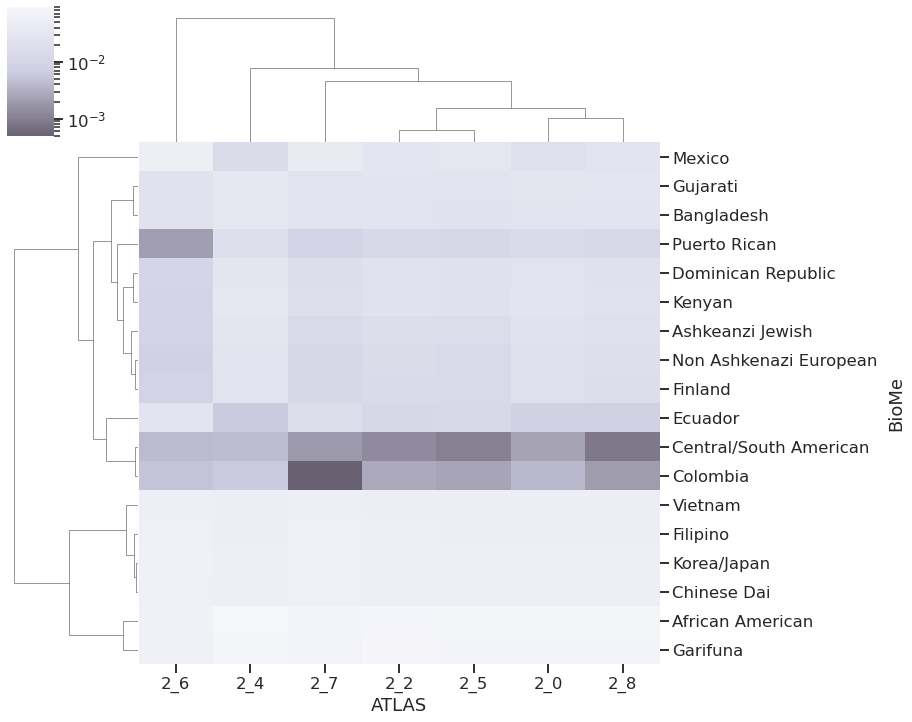

In [49]:
plt.rcParams['font.family'] = 'Myriad Pro'

g = sns.clustermap(fst_df, cmap=mycmap, figsize=(13, 10), yticklabels=1, norm=LogNorm())
ax = g.ax_heatmap

ax.set_ylabel("BioMe")
ax.set_xlabel("ATLAS")
# plt.show()
# plt.savefig("fst_gillian.eps", format='eps')


In [18]:
mex_subfiles = glob("azure/fst/mex2/mex2_*_*.afreq")

In [27]:
fst_mat = np.zeros(shape=(19, len(mex_subfiles)))

for i in range(1, 20):
    
    for k, j in enumerate(mex_subfiles):
        print(i, j)
        
        df1 = pd.read_csv(f"azure/gillian_maf/community{i}.txt", delimiter="\t", header=None)
        df1.columns = ["#CHROM", "ID", "REF", "ALT", "ALT_FREQS", "OBS_CT"]
        
        df2 = pd.read_csv(j, delimiter="\t")
            
        merge = df1.merge(df2, on=["ID"])
        merge["flip"] = np.where(merge["REF_x"]!=merge["REF_y"], 1-merge["ALT_FREQS_y"], merge["ALT_FREQS_y"])
            
        pop1 = merge[["ALT_FREQS_x", "OBS_CT_x"]].values
        pop2 = merge[["flip", "OBS_CT_y"]].values
        
        num, den = get_fst(pop1, pop2)

        fst = np.mean(num)/np.mean(den)
        fst_mat[i-1, k] = fst

        print(fst)

            
    

1 azure/fst/mex2/mex2_0_0.afreq
0.013312907496435922
1 azure/fst/mex2/mex2_0_3.afreq
0.015784860167237545
1 azure/fst/mex2/mex2_0_8.afreq
0.01573839318000828
1 azure/fst/mex2/mex2_2_0.afreq
0.013312907496435922
1 azure/fst/mex2/mex2_2_1.afreq
0.023048268753368698
1 azure/fst/mex2/mex2_2_3.afreq
0.015784860167237545
1 azure/fst/mex2/mex2_4_0.afreq
0.014904252061497595
1 azure/fst/mex2/mex2_4_2.afreq
0.012443523016489955
1 azure/fst/mex2/mex2_4_3.afreq
0.058304643333786474
1 azure/fst/mex2/mex2_5_0.afreq
0.011912600373253817
1 azure/fst/mex2/mex2_5_2.afreq
0.011978242406547202
1 azure/fst/mex2/mex2_5_5.afreq
0.01075838927165497
1 azure/fst/mex2/mex2_8_0.afreq
0.020291974338265274
1 azure/fst/mex2/mex2_8_1.afreq
0.008785178234947217
1 azure/fst/mex2/mex2_8_2.afreq
0.019030391571134304
1 azure/fst/mex2/mex2_8_3.afreq
0.011403878454539593
2 azure/fst/mex2/mex2_0_0.afreq
0.02141685586717313
2 azure/fst/mex2/mex2_0_3.afreq
0.025329883735730283
2 azure/fst/mex2/mex2_0_8.afreq
0.025974635922160

0.081283776758591
10 azure/fst/mex2/mex2_8_1.afreq
0.07990616182181431
10 azure/fst/mex2/mex2_8_2.afreq
0.07782144371324415
10 azure/fst/mex2/mex2_8_3.afreq
0.0733404764455743
11 azure/fst/mex2/mex2_0_0.afreq
0.0033084892851392377
11 azure/fst/mex2/mex2_0_3.afreq
0.004277513249131962
11 azure/fst/mex2/mex2_0_8.afreq
0.004469312479114482
11 azure/fst/mex2/mex2_2_0.afreq
0.0033084892851392377
11 azure/fst/mex2/mex2_2_1.afreq
0.012394531235648924
11 azure/fst/mex2/mex2_2_3.afreq
0.004277513249131962
11 azure/fst/mex2/mex2_4_0.afreq
0.003925370336154225
11 azure/fst/mex2/mex2_4_2.afreq
0.0027484491225968685
11 azure/fst/mex2/mex2_4_3.afreq
0.05514212147198315
11 azure/fst/mex2/mex2_5_0.afreq
0.002566871907433553
11 azure/fst/mex2/mex2_5_2.afreq
0.002630294916497383
11 azure/fst/mex2/mex2_5_5.afreq
0.0026299805171199875
11 azure/fst/mex2/mex2_8_0.afreq
0.006613252678029984
11 azure/fst/mex2/mex2_8_1.afreq
0.0017568556876156915
11 azure/fst/mex2/mex2_8_2.afreq
0.006197022925229844
11 azure/f

In [46]:
fst_df = pd.DataFrame(abs(fst_mat))

In [47]:
fst_df.columns = [m.split("/")[-1].split(".")[0] for m in mex_subfiles]

In [48]:
ylabels = pd.read_csv("gillian_communities", header=None, delimiter="\t")
fst_df["gillian number"] = list(range(1, 20))
fst_df = fst_df.merge(ylabels, left_on="gillian number", right_on=1)
fst_df = fst_df.set_index(0)
fst_df = fst_df.drop(["gillian number", 1], axis=1)

In [51]:
c = colormap.Colormap()
mycmap = c.cmap_linear("#696172", "#cfcfe3", "#f5f6fa")

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


Text(0.5, -10.5, 'ATLAS')

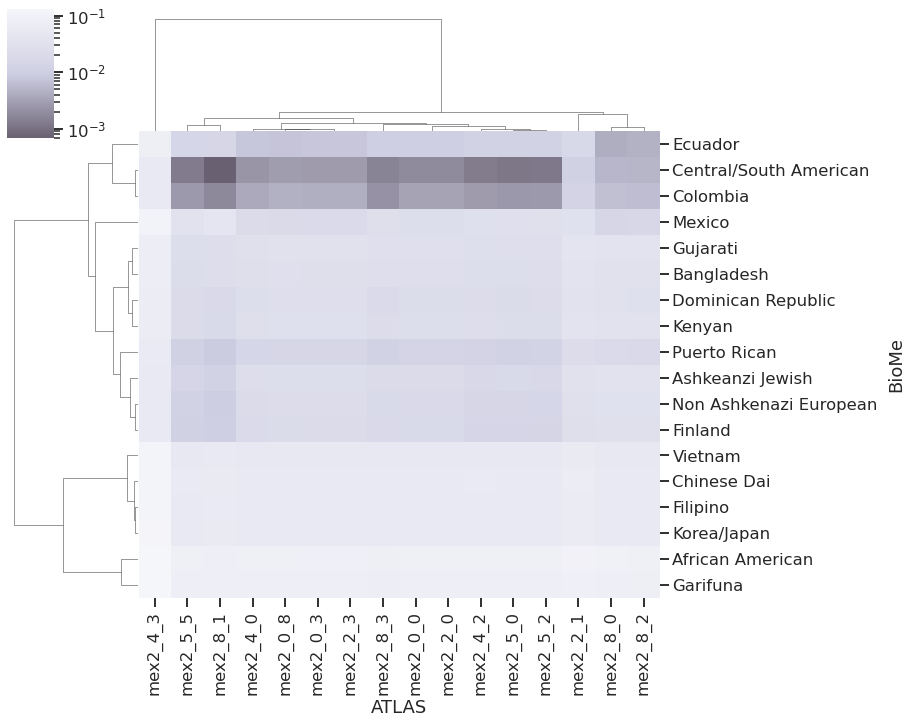

In [52]:
plt.rcParams['font.family'] = 'Myriad Pro'

g = sns.clustermap(fst_df, cmap=mycmap, figsize=(13, 10), yticklabels=1, norm=LogNorm())
ax = g.ax_heatmap

ax.set_ylabel("BioMe")
ax.set_xlabel("ATLAS")
# plt.show()
# plt.savefig("fst_gillian.eps", format='eps')


# mex ukbb

In [40]:
mex_uk = glob("azure/non_uk/amr/*.afreq")

In [41]:
# mex_subfiles = glob("azure/fst/mex2/mex2_*.afreq")
mex_subfiles = glob("azure/fst/mex2/mex2_*_*.afreq")

In [42]:
# mex_subfiles = []
# for i in [0, 2, 4, 5, 6, 7, 8]: 
#     mex_subfiles.append(f"azure/fst/mex2/mex2_{i}.afreq")

In [43]:
fst_mat = np.zeros(shape=(len(mex_uk), len(mex_subfiles)))

for i, p in enumerate(mex_uk):
    
    for k, j in enumerate(mex_subfiles):
        print(i, k)
        
        df1 = pd.read_csv(p, delimiter="\t")
        
        df2 = pd.read_csv(j, delimiter="\t")
            
        merge = df1.merge(df2, on=["ID"])
        merge["flip"] = np.where(merge["REF_x"]!=merge["REF_y"], 1-merge["ALT_FREQS_y"], merge["ALT_FREQS_y"])
            
        pop1 = merge[["ALT_FREQS_x", "OBS_CT_x"]].values
        pop2 = merge[["flip", "OBS_CT_y"]].values
        
        num, den = get_fst(pop1, pop2)
        num = np.ma.array(num, mask=np.isnan(num)) 
        den = np.ma.array(den, mask=np.isnan(den)) 

        fst = np.mean(num)/np.mean(den)
        fst_mat[i, k] = fst

        print(fst)

            
    

0 0
0.06497998666536262
0 1
0.06775140161906089
0 2
0.06678439743008802
0 3
0.06497998666536262
0 4
0.0749020958335734
0 5
0.06775140161906089
0 6
0.06642635281903315
0 7
0.06530474750682969
0 8
0.11310448584025912
0 9
0.0636745443366206
0 10
0.06445132410265997
0 11
0.06331557479526899
0 12
0.07165406186433855
0 13
0.060817978146455495
0 14
0.06890302750812255
0 15
0.06039205915514862
1 0
0.016879007216051917
1 1
0.020028578550307995
1 2
0.0210353361988937
1 3
0.016879007216051917
1 4
0.026465896823005507
1 5
0.020028578550307995
1 6
0.01941988040951589
1 7
0.01375635476958997
1 8
0.05505261116338129
1 9
0.013845309468870328
1 10
0.013410952179158919
1 11
0.01083664166484407
1 12
0.027724999600252848
1 13
0.00900983482937212
1 14
0.02753346579112535
1 15
0.017446764152468815
2 0
0.04590559866400549
2 1
0.04872728668966465
2 2
0.04797668856056697
2 3
0.04590559866400549
2 4
0.05492505939186394
2 5
0.04872728668966465
2 6
0.04746841572402715
2 7
0.04588398991212115
2 8
0.094206281065347

0.005782723586239099
20 3
0.005320299477876069
20 4
0.013663760390218507
20 5
0.005644258177199948
20 6
0.0054198196420272545
20 7
0.005142474488633279
20 8
0.06202422053017445
20 9
0.005027178257836267
20 10
0.005044757132868218
20 11
0.005596934756283923
20 12
0.007120791355234471
20 13
0.0051947082240148545
20 14
0.007244351177776824
20 15
0.005616976638337232
21 0
0.014068371252866831
21 1
0.016724275687007916
21 2
0.01737093290218982
21 3
0.014068371252866831
21 4
0.021933855508099585
21 5
0.016724275687007916
21 6
0.016121411557924795
21 7
0.011308772377167863
21 8
0.05318352583964306
21 9
0.011612216533540764
21 10
0.011179228258965074
21 11
0.008974336938016034
21 12
0.02348897862635805
21 13
0.007276317332990127
21 14
0.022935885053990596
21 15
0.01396425183625172
22 0
0.02055422425190042
22 1
0.0225152662738013
22 2
0.02239418823775323
22 3
0.02055422425190042
22 4
0.02986389978202372
22 5
0.0225152662738013
22 6
0.02182132161330551
22 7
0.01952421447695673
22 8
0.07065500129

In [45]:
fst_df = pd.DataFrame(abs(fst_mat))

In [46]:
mex_subfiles

['azure/fst/mex2/mex2_0_0.afreq',
 'azure/fst/mex2/mex2_0_3.afreq',
 'azure/fst/mex2/mex2_0_8.afreq',
 'azure/fst/mex2/mex2_2_0.afreq',
 'azure/fst/mex2/mex2_2_1.afreq',
 'azure/fst/mex2/mex2_2_3.afreq',
 'azure/fst/mex2/mex2_4_0.afreq',
 'azure/fst/mex2/mex2_4_2.afreq',
 'azure/fst/mex2/mex2_4_3.afreq',
 'azure/fst/mex2/mex2_5_0.afreq',
 'azure/fst/mex2/mex2_5_2.afreq',
 'azure/fst/mex2/mex2_5_5.afreq',
 'azure/fst/mex2/mex2_8_0.afreq',
 'azure/fst/mex2/mex2_8_1.afreq',
 'azure/fst/mex2/mex2_8_2.afreq',
 'azure/fst/mex2/mex2_8_3.afreq']

In [47]:
fst_df.columns = [m.split("/")[-1].split(".")[0][3:] for m in mex_subfiles]

In [48]:
fst_df.index = [m.split("/")[-1].split(".")[0] for m in mex_uk]

In [57]:
fst_df["2_4_3"].sort_values()

El_Salvador            0.052367
Puerto_Rico            0.053184
Argentina              0.055053
Venezuela              0.055110
Brazil                 0.055355
Uruguay                0.055440
Paraguay               0.055895
Bermuda                0.055897
Panama                 0.056767
Cuba                   0.057100
Bahamas                0.057605
Chile                  0.058165
Costa_Rica             0.059157
Belize                 0.059239
Colombia               0.059794
Mexico                 0.061127
Peru                   0.062024
Guatemala              0.066278
Saint_Helena           0.070655
Bolivia                0.072350
Ecuador                0.075858
The_Guianas            0.081499
Aruba                  0.094206
West_Indies            0.098148
Caribbean              0.111284
Antigua_and_Barbuda    0.113104
Barbados               0.118971
Name: 2_4_3, dtype: float64

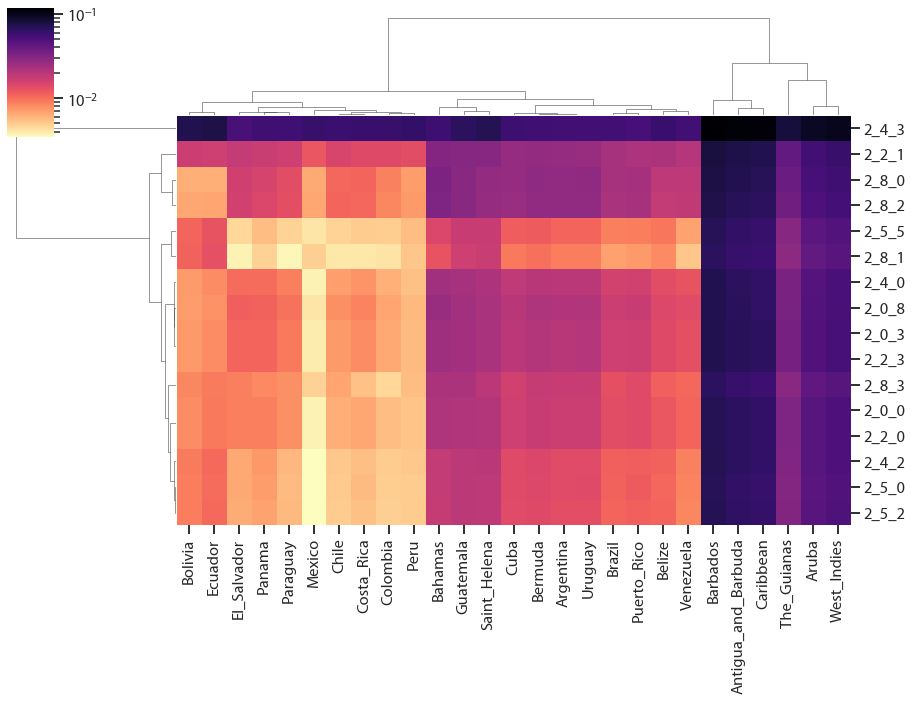

In [24]:
plt.rcParams['font.family'] = 'Myriad Pro'

g = sns.clustermap(fst_df.T, cmap="magma_r", figsize=(13, 10), yticklabels=1, norm=LogNorm())
ax = g.ax_heatmap

# ax.set_xlabel("UKBB")
# ax.set_ylabel("ATLAS")
# plt.show()
# plt.savefig("fst_gillian.eps", format='eps')


In [25]:
mex_afr_uk = list(glob("azure/non_uk/amr/*.afreq")) + list(glob("azure/non_uk/afr/*.afreq"))

In [26]:
mex_subfiles = []
# for i in [0, 2, 4, 5, 6, 7, 8]: 
#     mex_subfiles.append(f"azure/fst/mex2/mex2_{i}.afreq")
for i in [1, 2, 3]: 
    mex_subfiles.append(f"azure/fst/aa{i}.afreq")

In [27]:
fst_mat = np.zeros(shape=(len(mex_afr_uk), len(mex_subfiles)))

for i, p in enumerate(mex_afr_uk):
    
    for k, j in enumerate(mex_subfiles):
        
        df1 = pd.read_csv(p, delimiter="\t")
        
        df2 = pd.read_csv(j, delimiter="\t")
            
        merge = df1.merge(df2, on=["ID"])
        merge["flip"] = np.where(merge["REF_x"]!=merge["REF_y"], 1-merge["ALT_FREQS_y"], merge["ALT_FREQS_y"])
            
        pop1 = merge[["ALT_FREQS_x", "OBS_CT_x"]].values
        pop2 = merge[["flip", "OBS_CT_y"]].values
        
        num, den = get_fst(pop1, pop2)
        num = np.ma.array(num, mask=np.isnan(num)) 
        den = np.ma.array(den, mask=np.isnan(den)) 

        fst = np.mean(num)/np.mean(den)
        fst_mat[i, k] = fst

        print(i, k, fst)

0 0 0.0034948495115244478
0 1 0.010658538735881238
0 2 0.008203680523833034
1 0 0.06279994390810636
1 1 0.03276245812320072
1 2 0.100205518617334
2 0 0.004309680633567054
2 1 0.004403091939017467
2 2 0.015593770790438053
3 0 0.06713699947840703
3 1 0.03650988151014788
3 2 0.10509818315010751
4 0 0.0042822450664937485
4 1 0.01288850857079149
4 2 0.007542931788743274
5 0 0.031437045644795845
5 1 0.012246614064480304
5 2 0.06003250547089288
6 0 0.049917989654031596
6 1 0.0236836358980053
6 2 0.0841712996428868
7 0 0.07603012953169623
7 1 0.04851098585933839
7 2 0.11256493602042993
8 0 0.04738818280773956
8 1 0.021969724442777856
8 2 0.08106608596422799
9 0 0.0037404070853556282
9 1 0.010001945391524443
9 2 0.00933537371385923
10 0 0.06281924684935752
10 1 0.03436288439553774
10 2 0.09942529501302115
11 0 0.05445690618596257
11 1 0.02893177040059639
11 2 0.0887450405384954
12 0 0.0613329979137535
12 1 0.033558679699775336
12 2 0.09752240609269391
13 0 0.03844231184806954
13 1 0.01607060329

In [28]:
fst_df = pd.DataFrame(abs(fst_mat))

In [29]:
fst_df.columns = [m.split("/")[-1].split(".")[0] for m in mex_subfiles]

In [30]:
fst_df.index = [m.split("/")[-1].split(".")[0] for m in mex_afr_uk]

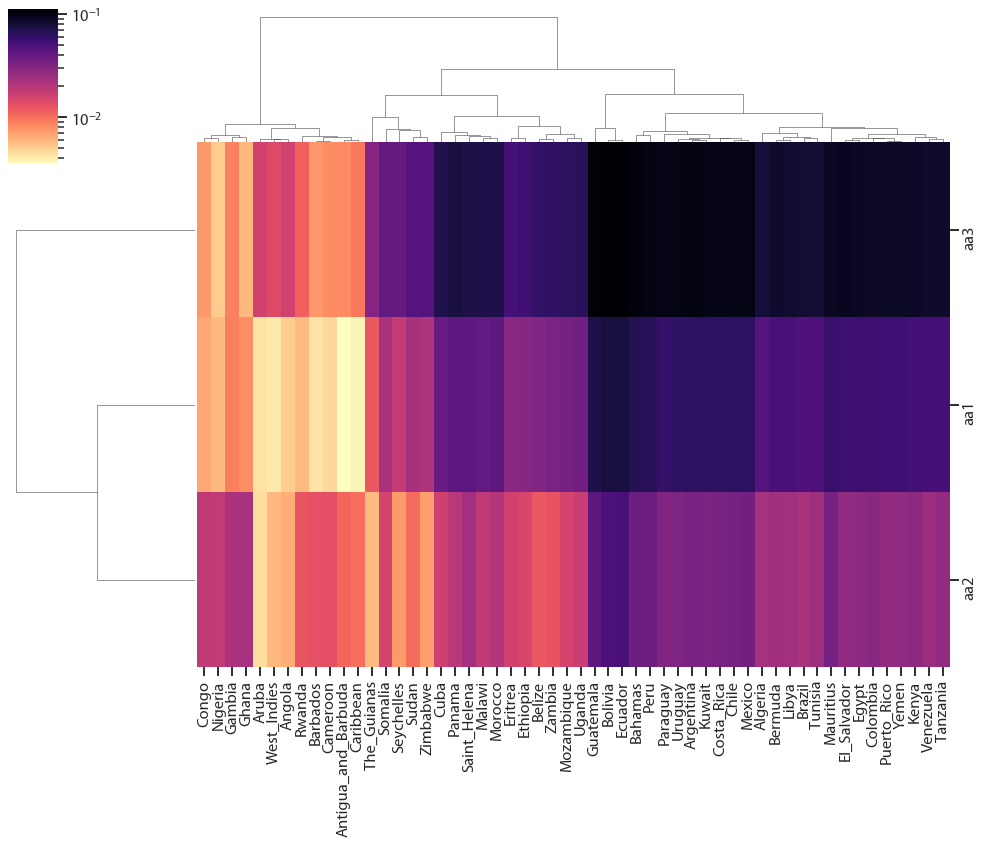

In [37]:
plt.rcParams['font.family'] = 'Myriad Pro'

g = sns.clustermap(fst_df.T, cmap="magma_r", figsize=(14, 12), xticklabels=1, norm=LogNorm())
ax = g.ax_heatmap

# ax.set_ylabel("UKBB")
# ax.set_xlabel("ATLAS")
# plt.show()
# plt.savefig("fst_gillian.eps", format='eps')


In [39]:
fst_df["aa3"].sort_values()

Nigeria                0.005105
Ghana                  0.005798
Congo                  0.007422
Barbados               0.007543
Cameroon               0.008043
Antigua_and_Barbuda    0.008204
Gambia                 0.008774
Caribbean              0.009335
Rwanda                 0.011094
West_Indies            0.013998
Aruba                  0.015594
Angola                 0.015613
The_Guianas            0.029917
Seychelles             0.039304
Somalia                0.040336
Zimbabwe               0.045377
Sudan                  0.045473
Eritrea                0.051443
Ethiopia               0.053927
Belize                 0.060033
Zambia                 0.061506
Mozambique             0.062879
Uganda                 0.064119
Cuba                   0.069463
Malawi                 0.071366
Morocco                0.071905
Saint_Helena           0.072223
Panama                 0.075374
Algeria                0.077531
Tunisia                0.080985
Brazil                 0.081066
Libya   